# Análise de pKa com propKa3

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
from cycler import cycler

In [3]:
# Define font sizes
SIZE_DEFAULT = 18
SIZE_LARGE = 18
plt.rc("font", family="Arial", weight='bold')  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

In [4]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = cycler(color=CB_color_cycle)


## Funções

In [19]:
def process_pka(df_path, num_cadeias, nome_colunas=['Resíduo', 'pKa', 'pKa modelo']):
    """
    Transforma um arquivo .csv gerado do resumo do .pKa em um dicionário contendo as
    cadeias como chaves e os dataframes com as informações sobre Resíduo, pKa e pKa modelo.
    """
    df = pd.read_csv(df_path, sep=";", engine="python")
    df.columns = nome_colunas

    df['Cadeia'] = df['Resíduo'].str[-1]

    dicio_cadeias = {}

    for cadeia in num_cadeias:
        # Filtra por cadeia
        dicio_cadeias[cadeia] = df[df['Cadeia'] == cadeia].reset_index(drop=True)

        # Remove a letra da cadeia do nome do resíduo
        dicio_cadeias[cadeia]['Resíduo'] = dicio_cadeias[cadeia]['Resíduo'].str[:-1]

    return dicio_cadeias


def plot_pka(
    dicio, keys, cores, labels, titulo, nome_save,
    forma_legenda=Patch, xlabel='Resíduo', ylabel='pKa', marcar_anormais=False
):
    """
    Plota um gráfico para cada cadeia mostrando pKa vs resíduo.
    Se marcar_anormais=True, o eixo X só mostra resíduos com pKa anormal.
    Salva cada gráfico em .jpg.
    """

    if not isinstance(keys, list):
        keys = list(keys)

    # Definição de resíduos ácidos e básicos
    acidos = ["ASP", "GLU"]
    basicos = ["ARG", "LYS"]

    for cadeia, t in zip(keys, titulo):
        df = dicio[cadeia].copy()
        df['Tipo'] = df['Resíduo'].str[:3]

        # Criar mapa de cores
        tipos_unicos = df['Tipo'].unique()
        cor_map = {tipo: cores[i % len(cores)] for i, tipo in enumerate(tipos_unicos)}
        cores_barras = df['Tipo'].map(cor_map)

        # Criar legenda
        legenda = [forma_legenda(facecolor=cor_map[t], label=t) for t in tipos_unicos]
        legenda.append(Line2D([0], [0], ls='--', color='black', lw=2, label='pKa = 6.5'))

        # Plot
        plt.figure(figsize=(12, 4))
        plt.bar(df['Resíduo'], df['pKa'], color=cores_barras)
        plt.axhline(y=7, color='black', linestyle='--')

        # Definir rótulos do eixo X
        if marcar_anormais:
            mask_anormais = (
                ((df['Tipo'].isin(acidos)) & ((df['pKa'] < 0) | (df['pKa'] > 6.5))) |
                ((df['Tipo'].isin(basicos)) & (df['pKa'] <= 6.5))
            )
            labels_x = [res if anormal else "" for res, anormal in zip(df['Resíduo'], mask_anormais)]
            plt.xticks(range(len(df)), labels_x, rotation=90)
        else:
            # Mostrar todos de forma espaçada
            plt.xticks(range(0, len(df), 5), df['Resíduo'][::5], rotation=90)

        # Título e legenda
        plt.title(t)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(handles=legenda, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

        # Intervalo dos ticks no eixo Y
        ymin, ymax = round(min(df['pKa'])), round(max(df['pKa']))
        plt.yticks(np.arange(ymin, ymax + 1, 2))

        plt.tight_layout()
        plt.savefig(f'{nome_save}_{cadeia}.jpg', dpi=400)
        plt.show()


## MER

In [20]:
dict_mer = process_pka('pka_formatado_3colunas.csv', ['A','B','C','D'])

#print(dict_mer)


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(dict_mer)
    pass

for cadeia in dict_mer.keys():
    df = dict_mer[cadeia]

    # Máscara para remover resíduos indesejados
    mask_remover = (
        df['Resíduo'].isin(['N+1', 'C-327']) |   # terminais
        df['Resíduo'].str.startswith('CYS') |    # todas as Cisteínas
        df['Resíduo'].str.startswith('TYR')      # todas as Tirosinas
    )

    # Mantém apenas os que não estão na máscara
    df = df[~mask_remover].reset_index(drop=True)

    dict_mer[cadeia] = df

    # Prints de conferência
    print(f"N-terminal da cadeia {cadeia} removido? {'N+1' not in df['Resíduo'].values}")
    print(f"C-terminal da cadeia {cadeia} removido? {'C-327' not in df['Resíduo'].values}")
    print(f"Alguma CYS sobrou na cadeia {cadeia}? {any(df['Resíduo'].str.startswith('CYS'))}")
    print(f"Alguma TYR sobrou na cadeia {cadeia}? {any(df['Resíduo'].str.startswith('TYR'))}")

N-terminal da cadeia A removido? True
C-terminal da cadeia A removido? True
Alguma CYS sobrou na cadeia A? False
Alguma TYR sobrou na cadeia A? False
N-terminal da cadeia B removido? True
C-terminal da cadeia B removido? True
Alguma CYS sobrou na cadeia B? False
Alguma TYR sobrou na cadeia B? False
N-terminal da cadeia C removido? True
C-terminal da cadeia C removido? True
Alguma CYS sobrou na cadeia C? False
Alguma TYR sobrou na cadeia C? False
N-terminal da cadeia D removido? True
C-terminal da cadeia D removido? True
Alguma CYS sobrou na cadeia D? False
Alguma TYR sobrou na cadeia D? False


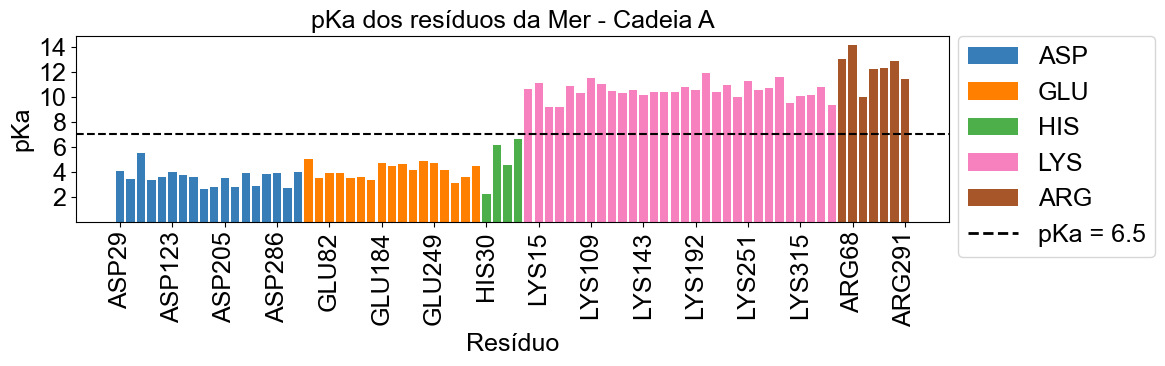

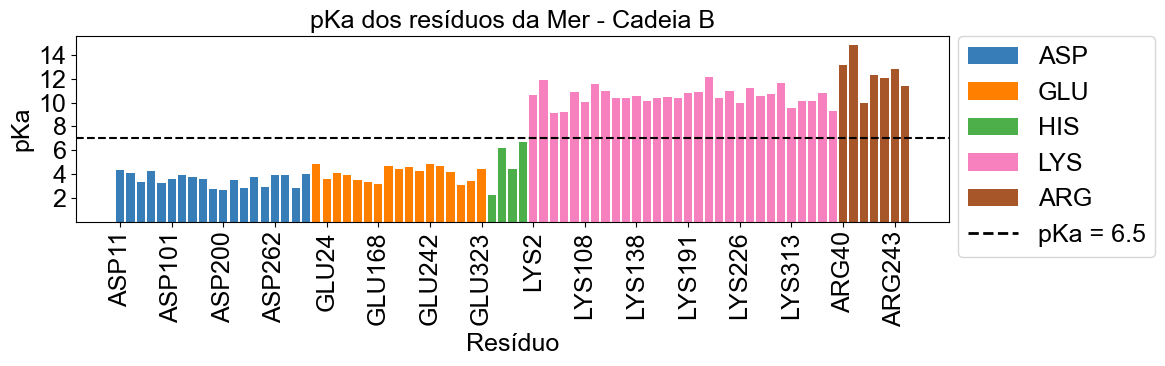

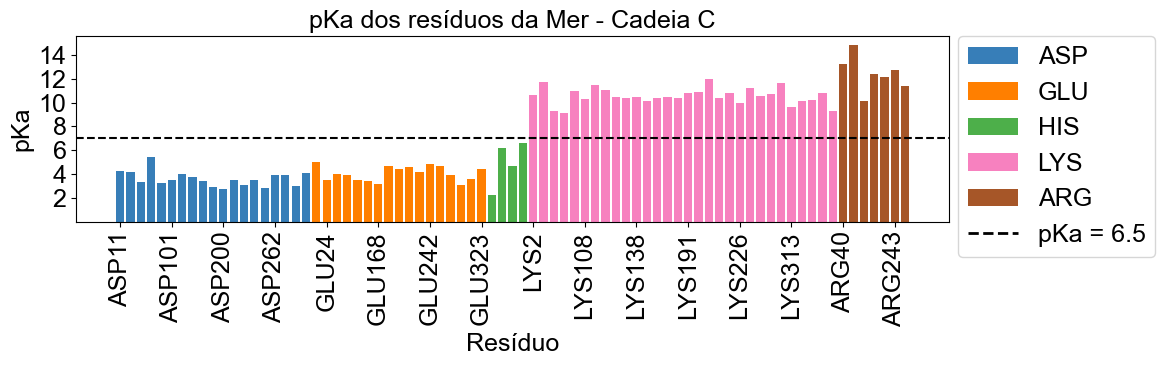

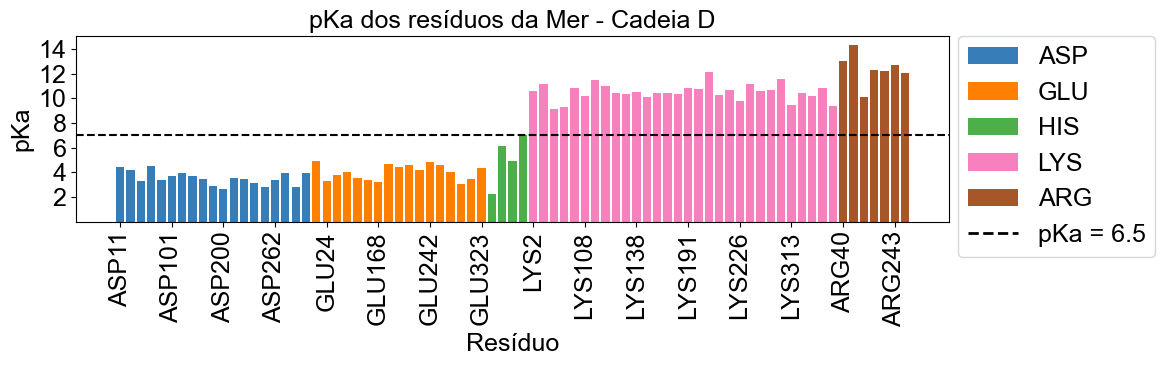

In [21]:
labels = ['ASP', 'GLU', 'N-terminal', 'HIS', 'CYS', 'TYR', 'LYS', 'ARG', 'C-terminal']

cores = ['#377eb8', '#ff7f00', '#4daf4a',
         '#f781bf', '#a65628', '#984ea3',
         '#999999', '#e41a1c', '#dede00']

titulos = ['pKa dos resíduos da Mer - Cadeia A', 'pKa dos resíduos da Mer - Cadeia B', 
           'pKa dos resíduos da Mer - Cadeia C', 'pKa dos resíduos da Mer - Cadeia D']

plot_pka(dict_mer, list(dict_mer.keys()), cores, labels, titulos, 'pKa_mer_1mer')

## MCR

In [22]:
output_path = "pka_mcr6mer_3colunas.csv"

with open("RESUMO_mcr_6mer_pka.txt", "r") as f:
    linhas = f.readlines()

linhas_formatadas = []
for linha in linhas:
    linha = linha.strip()
    if not linha or linha.startswith("Group"):
        continue
    partes = linha.split()
    if len(partes) >= 4:
        identificador = f"{partes[0]}{partes[1]}"  # ResiduoNumero + Cadeia
        valor1 = partes[2]
        valor2 = partes[3]
        linhas_formatadas.append(f"{identificador};{valor1};{valor2}")

with open(output_path, "w") as f:
    f.write("\n".join(linhas_formatadas))

print(f"Arquivo salvo com {len(linhas_formatadas)} linhas em {output_path}")


Arquivo salvo com 715 linhas em pka_mcr6mer_3colunas.csv


In [23]:
dict_mcr = process_pka('pka_mcr6mer_3colunas.csv', ['A', 'B','C','D', 'E', 'F'])

for cadeia in dict_mcr.keys():
    dict_mcr[cadeia]['pKa'] = dict_mcr[cadeia]['pKa'].astype(float)
#dict_mcr

for cadeia in dict_mcr.keys():
    df = dict_mcr[cadeia]

    # Máscara para remover resíduos indesejados
    mask_remover = (
        df['Resíduo'].isin(['N+1', 'C-327']) |   # terminais
        df['Resíduo'].str.startswith('CYS') |    # todas as Cisteínas
        df['Resíduo'].str.startswith('TYR')      # todas as Tirosinas
    )

    # Mantém apenas os que não estão na máscara
    df = df[~mask_remover].reset_index(drop=True)

    dict_mcr[cadeia] = df

    # Prints de conferência
    print(f"N-terminal da cadeia {cadeia} removido? {'N+1' not in df['Resíduo'].values}")
    print(f"C-terminal da cadeia {cadeia} removido? {'C-327' not in df['Resíduo'].values}")
    print(f"Alguma CYS sobrou na cadeia {cadeia}? {any(df['Resíduo'].str.startswith('CYS'))}")
    print(f"Alguma TYR sobrou na cadeia {cadeia}? {any(df['Resíduo'].str.startswith('TYR'))}")

N-terminal da cadeia A removido? True
C-terminal da cadeia A removido? True
Alguma CYS sobrou na cadeia A? False
Alguma TYR sobrou na cadeia A? False
N-terminal da cadeia B removido? True
C-terminal da cadeia B removido? True
Alguma CYS sobrou na cadeia B? False
Alguma TYR sobrou na cadeia B? False
N-terminal da cadeia C removido? True
C-terminal da cadeia C removido? True
Alguma CYS sobrou na cadeia C? False
Alguma TYR sobrou na cadeia C? False
N-terminal da cadeia D removido? True
C-terminal da cadeia D removido? True
Alguma CYS sobrou na cadeia D? False
Alguma TYR sobrou na cadeia D? False
N-terminal da cadeia E removido? True
C-terminal da cadeia E removido? True
Alguma CYS sobrou na cadeia E? False
Alguma TYR sobrou na cadeia E? False
N-terminal da cadeia F removido? True
C-terminal da cadeia F removido? True
Alguma CYS sobrou na cadeia F? False
Alguma TYR sobrou na cadeia F? False


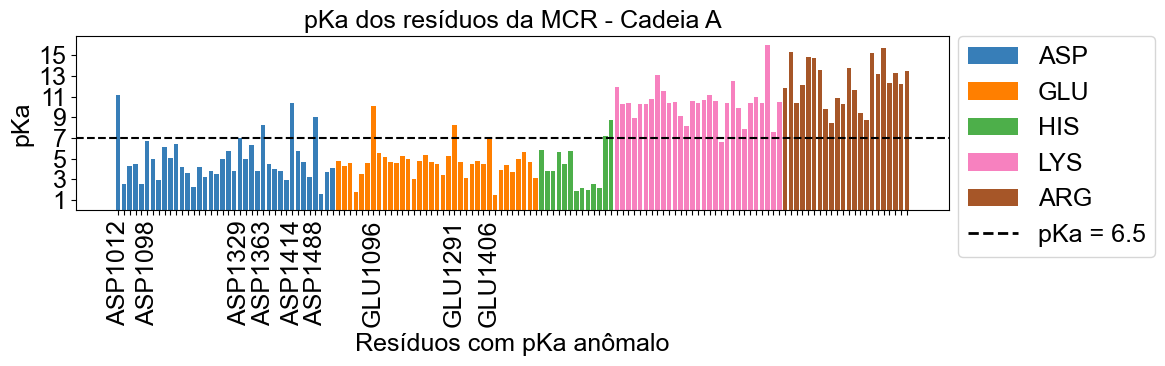

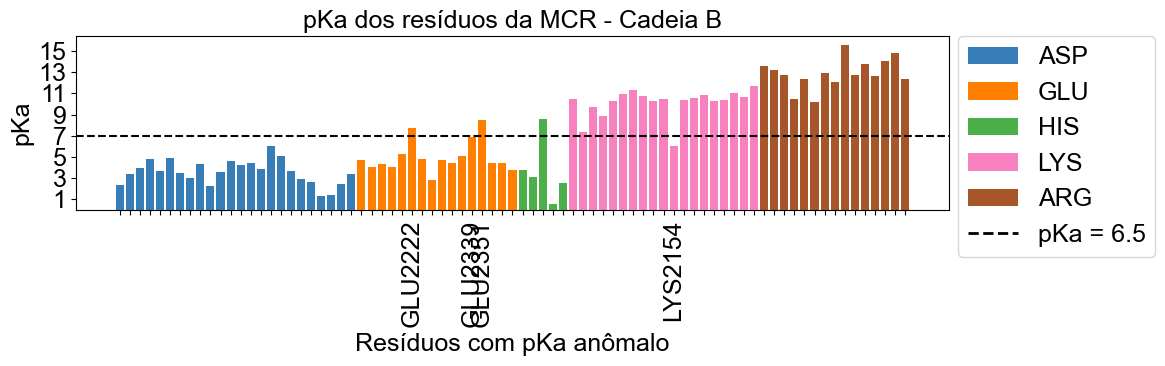

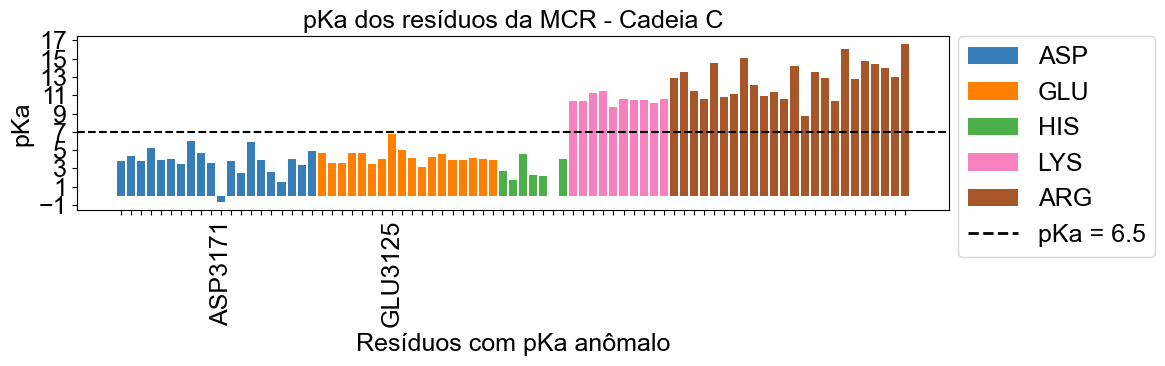

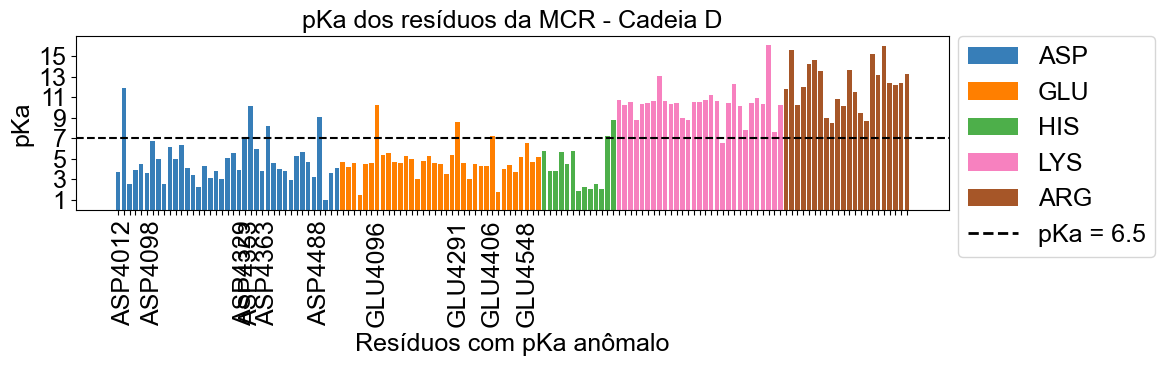

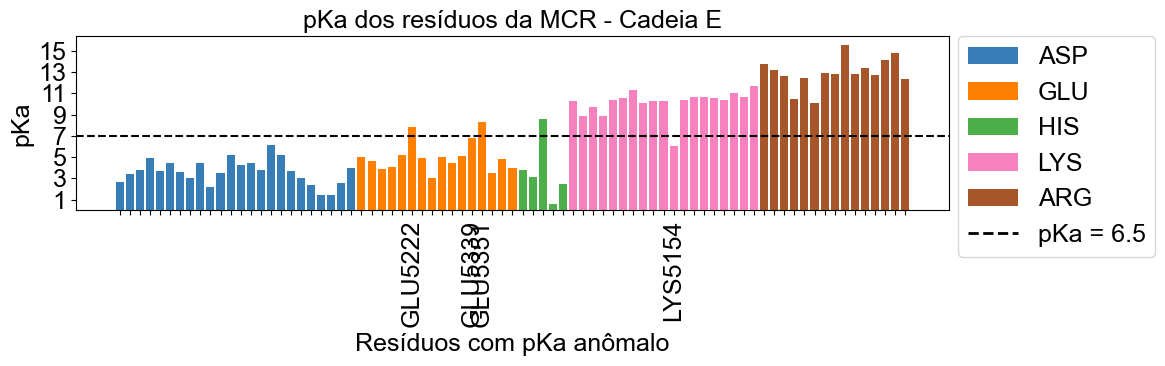

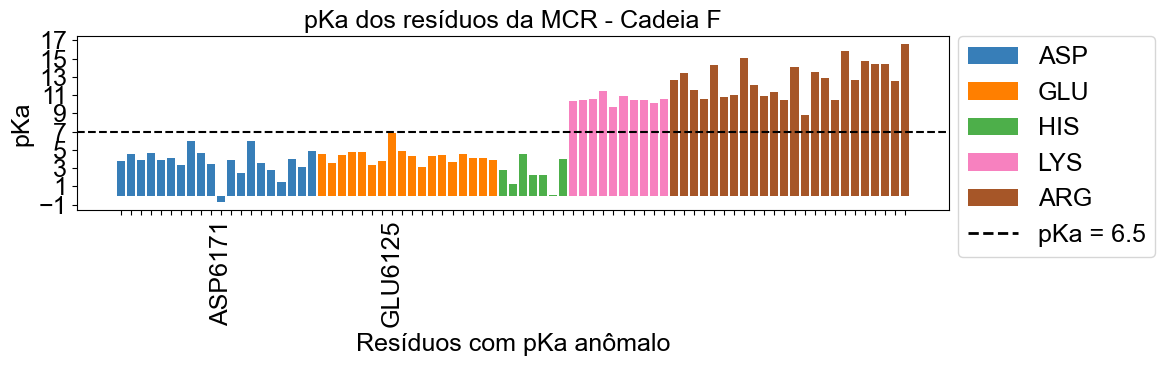

In [24]:
labels = ['ASP', 'GLU', 'N-terminal', 'HIS', 'CYS', 'TYR', 'LYS', 'ARG', 'C-terminal']

cores = ['#377eb8', '#ff7f00', '#4daf4a',
         '#f781bf', '#a65628', '#984ea3',
         '#999999', '#e41a1c', '#dede00']

titulos = ['pKa dos resíduos da MCR - Cadeia A', 'pKa dos resíduos da MCR - Cadeia B', 
           'pKa dos resíduos da MCR - Cadeia C', 'pKa dos resíduos da MCR - Cadeia D',
           'pKa dos resíduos da MCR - Cadeia E', 'pKa dos resíduos da MCR - Cadeia F']

plot_pka(dict_mcr, list(dict_mcr.keys()), cores, labels, titulos, 'pka_mcr_1mer', xlabel='Resíduos com pKa anômalo', marcar_anormais=True)